In [200]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [208]:
def mk_idx_list(n, d):
    idcs = list(itertools.product(*(range(n) for i in range(d))))
    idcs = sorted(idcs, key=lambda x: max(x) * (n * d) + sum(x))
    return idcs

In [307]:
def eval_basis(xs, i, O):
    N = xs.shape[1] # Number of dimensions

    idcs = []
    for _ in range(N):
        idcs.append(i % O)
        i //= O

    res = np.ones(xs.shape[0])
    for i in range(N):
        res *= np.polynomial.Legendre([0] * idcs[i] + [1])(xs[:, i])
    return res

def lstsq(A, Y, sigma=0.1):
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)
    n, m = A.shape
    d = Y.shape[1]
    ATA = A.T @ A + n * np.square(sigma) * np.eye(m)
    D = np.zeros((m, d))
    for i in range(d):
        D[:, i] = np.linalg.solve(ATA, A.T @ Y[:, i])
    return D


def halton(i, b):
    f = 1
    r = 0
    while i > 0:
        f = f / b
        r = r + f * (i % b)
        i = i // b
    return r

def mk_activities(N_neurons, N_dims, N_smpls=10000, rng=np.random):
    max_rates = rng.uniform(0.5, 1.0, N_neurons)
    x_intercepts = rng.uniform(-1.0, 1.0, N_neurons)

    gains = max_rates / (1.0 - x_intercepts)
    biases = -x_intercepts * max_rates / (1.0 - x_intercepts)

    encoders = rng.normal(0, 1, (N_neurons, N_dims))
    encoders /= np.linalg.norm(encoders, axis=1)[:, None]

    primes = [2, 3, 5, 7, 11]

    Xs = np.array([
        2.0 * np.array([halton(i, primes[j]) for i in range(N_smpls)]) - 1.0
        for j in range(N_dims)
    ]).T

    Js = gains * (Xs @ encoders.T) + biases
    As = np.clip(Js, 0, None)

    return Xs, As

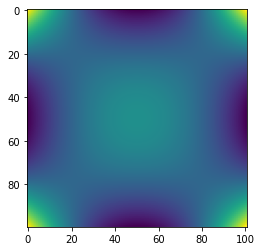

In [308]:
xs = np.linspace(-1, 1, 101)
ys = np.linspace(-1, 1, 100)
xss, yss = np.meshgrid(xs, ys)
zss = np.array((
    xss.flatten(),
    yss.flatten(),
)).T
fig, ax = plt.subplots()
ax.imshow(eval_basis(zss, 12, 5).reshape(len(ys), len(xs)))

In [309]:
O = 10
N_NEURON_TRIALS = 10
STATS = []
for j in np.geomspace(10, 1000, 10, dtype=np.int):
    ax.set_prop_cycle(None)
    res = []
    for d in range(1, 3):
        Xs, As = mk_activities(j, d)
        n_ok = 0
        for i in range(O ** d):
            Ys = eval_basis(Xs, i, O)
            D = lstsq(As, Ys)
            E = np.sqrt(np.mean(np.square((As @ D).flatten() - Ys.flatten()))) / np.sqrt(np.mean(np.square(Ys.flatten())))
            if E < 0.1:
                n_ok += 1
        res.append(n_ok)
    STATS.append(res)

In [310]:
STATS = np.array(STATS)

In [311]:
STATS

array([[ 0,  1],
       [ 2,  3],
       [ 2,  2],
       [ 3,  3],
       [ 3,  4],
       [ 4,  6],
       [ 5,  6],
       [ 5,  8],
       [ 6, 10],
       [ 7, 11]])